# GAN Image Generation - Week 5 Project

## Package Import

In [1]:
# Pacakge for picture display in IPython Jupyter Notebooks
from IPython import display

# Standard Packages for Data Analysis
import numpy as np 
import pandas as pd 

# Environment Packages for OS, time, saving and utility functions
import os
import time
import shutil
import json

# Python Image Library for picture creation and manipulation
import PIL

# Deep Learning Packages
import tensorflow as tf
from tensorflow.keras import layers

# Plotting Environment
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## Problem Description

The problem at hand can be framed in two ways. Either we can use the available data for a generator challenge, generating monet-style images from scratch or we might build more of a transformer model, that converts photos to monet-style images. We have choosen the former approach. In both cases the predictions are powered by a dataset of 300 monet-style drawings. Image Generation is, as of now, a highly relevant task in the field of machine learning, as it has the potential to simplify the life of creative professionals to a great extent. However, there are also downsides. Calls to regulate AI are especially loud in this area, as computer generated images, or even videos, have great potential to disrupt both trust in the media as well as between people in society. Because of that, understanding the inner workings, pitfalls, problems and chances of these models is key to navigate the future, especially as a Data Scientist.

## Data Format

I will use the tfrecord format during this competition, as I would like to explore a new dataformat. 

tfrecord is a specific data format, used with tensorflow. It is binary, and leads to efficient loading times of input data.

As the tfrecord files are already provided in this challenge, I will not have to create them by myself. According to different texts (https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564) this could be a tedious process.

I will follow the steps in the CycleGAN example notebook (https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) to import the data from the tfrecord files given.

## Model Architecture

I have decided, to use a DCGAN architecture. DCGAN stands for Deep Convolutional Generative Adversarial Network. This choice defines a fundamental basis for the approach to this project, as it implies that I will create Monet-style paintings from scratch instead of transforming existing pictures. This is due to the fact, that DCGANs do not contain an additional loss function, that compares an existing image with itself, after a double transformation, as is proposed for example in CycleGANs (Zhu, Park et al. 2020, Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Network).

DCGANs as well as GANs in general consist of a Generator and a Discriminator. It is the Generators task to create images, that are good enough to trick the Discriminator in believing, that they are real. On the other hand, it is the Discriminator, who tries to differentiate real from fake images. So we have to train two models, with their respective loss functions.

The specific DCGAN architecture, that we have used, is adapted from the one described at the tensorflow tutorial for DCGANs, which is available over the following link: https://www.tensorflow.org/tutorials/generative/dcgan

After taking random input the Generator consists of stacked Transformed 2D Convolutional layers. These layers basically reverse the known convolutional step, in expanding the image from central pixels, with a defined filter-size and stride. These layers are stacked until the target image size of 256x256 pixels is reached. Furthermore as a first step of the model, there is a dense layer, which means that we basically turn around the network architecture, that we would use to classify an image. These techniques are combined with Batch Normalization Layers, that try to prevent us from the problem of vanishing gradients, This problem would otherwise strongly affect our training result.

The discriminator on the other hand consists of a classical architecture, that also combines Convolution and Dense Layers, however this time in this well-known order. Moreover, we partly add dropout layers to reduce overfitting.

In the following we will start by implementing a first model and the necessary utility functions. During this process we will use and adapt code from the above mentioned sources.



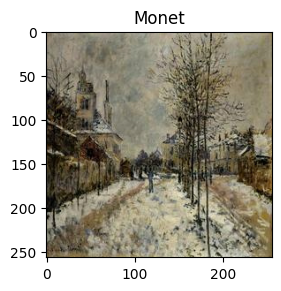

In [15]:
# Definition of the number of pictures per batch (total of 300 pictures available)
BATCH_SIZE = 64

# List of all filepaths to the pictures
file_names_monet = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')

# Variable to define the image size
im_sz = [256, 256]

# Function to decode the images to tensorflow tensors with rgb values betwen 0 and 1
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5)-1
    image = tf.reshape(image, [*im_sz, 3])
    return image

# Function to read from tfrecord files
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# Function to read the dataset set using the functions above
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

# Writing the whole dataset to the variable monet_ds
monet_ds = load_dataset(file_names_monet).batch(BATCH_SIZE)

# Plotting an example image from the dataset
example_monet = next(iter(monet_ds))

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0]*0.5+0.5)

As mentioned above, we will create a model based on the architecture given in the DCGAN example of tensorflow. However, as our dataset is different from the one in the example, we will have to adapt the model to our needs. This means, that we will have to add additional sequences of Conv2DTranspose and Batch Normalization layers, that will bring our output to the necessary size of 256 by 256 pixels and three RGB-channels or layers.

In [16]:
# Generator taking a input vector of shape (100,) with random float values
# an transforming it via multiple transposed convolution layers
# combined with batch normalization and leaky relu activation to 
# 256x256 pixel sized rgb images
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*192, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 

    model.add(layers.Reshape((8, 8, 192)))
    
    model.add(layers.Conv2DTranspose(192, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(96, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(48, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(24, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [17]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
    model.add(layers.BatchNormalization()) # newnew removed according to paper
    model.add(layers.Dropout(0.3))
    

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [18]:
# Functions to define the loss functions of generator and discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)#

# Definition of the Optimization Procedure using Adam Optimization
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Defintion of maximum epochs, dimension of random input noise and number of example pictures
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

# Variable containing all random values to generate the target amount of images
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Code to define the Save Directory of the intermediate model steps during training
generator_save_dir = '/kaggle/working/trained_models'
mod_save_prefix = os.path.join(generator_save_dir, "mod-")

# Function to generate and save test images during training
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
      plt.axis('off')

  plt.savefig('/kaggle/working/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [19]:
# In accordance with the CycleGAN Kaggle example notebook we will compile
# the training function due to performance reasons
# In fact we will use exactly the same training function
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    
    gen_losses = []
    disc_losses = []
    
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
      gen_losses.append(gen_loss)
      disc_losses.append(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return(gen_losses,disc_losses)

In [20]:
# Overlying training function activating each training step.
# We have added an output for the losses of generator and discriminator,
# which can be plotted afterwards.
# Furthermore we will save our intermediate models with this step.
def train(dataset, epochs):
  
  losses = []  
  for epoch in range(epochs):
    
    lo = []
    start = time.time()
    for image_batch in dataset:
      l = train_step(image_batch)
      lo.append(l)
    
    losses.append(lo)
    
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
      generator.save(mod_save_prefix+str(epoch+1))
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

  gen_l = [[float(j[0].numpy()) for j,k in i] for i in losses]
  gen_l = [np.mean(i) for i in gen_l]
  disc_l = [[float(k[0].numpy()) for j,k in i] for i in losses]
  disc_l = [np.mean(i) for i in disc_l]
    
  with open('/kaggle/working/gen_losses.json', 'w') as json_file:
    json.dump(gen_l, json_file)
  with open('/kaggle/working/disc_losses.json', 'w') as json_file:
    json.dump(disc_l, json_file)
    
  plt.plot(list(range(epochs)),gen_l,label='Generator_Loss')
  plt.plot(list(range(epochs)),disc_l,label='Discriminator_Loss')
  plt.legend()
  plt.savefig('/kaggle/working/losses.png')

In [ ]:
train(monet_ds, EPOCHS)

The performance of our first model is not that good. As we can see in the following example images, that the model is not able to generate recognizeable images after the maximum number of defined epochs.

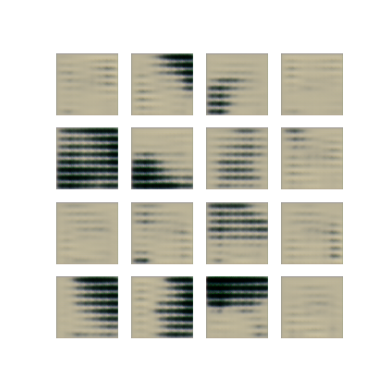

In [24]:
img = mpimg.imread('/kaggle/input/images-model-01/images_model_01.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

## Hyperparameter Optimzation

During hyperparameter optimization we will try different model architectures and learning parameters to improve our generated pictures. The ideas for these architectures are based on several papers and kaggle notebooks. The following sources should therefore be mentioned.

- Redford & Metz 2016, UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS
- Goodfellow et. al 2014, Generative Adversarial Nets
- Goodfellow 2016, NIPS 2016 Tutorial: Generative Adversarial Networks
- Salimans et. al 2016, Improved Techniques for Training GANs
- Curtó et. al 2020, High-resolution Deep Convolutional Generative Adversarial Networks
- https://www.kaggle.com/code/clementdelteil/dcgan-architectures-on-monet-s-paintings

In the following, I will list the parameters, that have been varied, in a compat fashion, using a table. The single models will not be mentioned in detail with code in this notebook, as this would inflate the total length of this work considerably. However, one should be able to re-run the resepective models, if necessary, with the help of the descriptions in this table.

I will only include the code for the final model, that has been submitted to the Kaggle competition, at the end of this notebook.

| Parameter | Model 1 | Model 2 | Model 3 | Model 4 | Model 5 |
|-----------|-----------|-----------|-----------|-----------|-----------|
| Batch Size    |    64       |     64      |     32      |     32      |     32      |
|-----------|-----------|-----------|-----------|-----------|-----------|
| ***Generator***     |           |           |           |           |           |
| Activation     |    LeakyRelu       |      LeakyRelu     |     Relu      |    Relu       |    LeakyRelu        |
| Stride 1st Conv.     |      2     |     1      |     1      |    2       |    2       |
| Stride last Conv.    |      2     |      2     |     2      |     2      |     1      |
| Conv Filter Size    |    5       |     4      |     4      |     4      |     3      |
| # Conv. Layers     |     5      |      5     |     5      |      6     |     5      |
| Dense Activation     |     Yes      |   Yes       |     Yes      |    Yes       |     No      |
| Batch Normalization     |    Yes       |    Yes       |     Yes      |     Yes      |    No       |
|-----------|-----------|-----------|-----------|-----------|-----------|
| ***Discriminator***     |           |           |           |           |       |
| Dropout @ each     |    Yes       |    No       |    No       |     No      |     No      |
| Dropout @ end    |    Yes       |      No     |      No     |     No      |   Yes        |
| Activation    |      None     |     LeakyRelu      |    LeakyRelu       |    LeakyRelu       |    LeakyRelu      |
| # Dense Layers    |    1       |     2      |     1      |     1      |      1     |
| # Conv. Layers    |    3       |      3     |     3      |     6      |     5      |
| Maxpooling 2x2    |     No      |     Yes      |   No       |    No       |    No       |
|-----------|-----------|-----------|-----------|-----------|-----------|
| ***Learning***   |           |           |           |           |           |
| Learning Rate     |    1e-4       |   1e-4        |    4e-4       |      2e-4     |     2e-4      |
| $\beta_1$    |     0.9      |   0.9      |   0.5        |    0.5       |      0.5     |


In the following I will plot the images, resulting from the models two to five. We have already seen, that the first model yields unsatisfactory results.

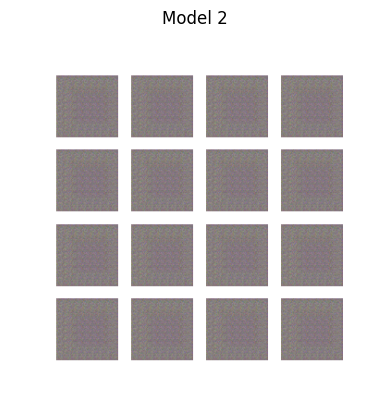

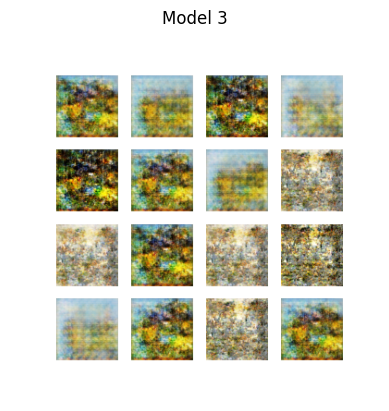

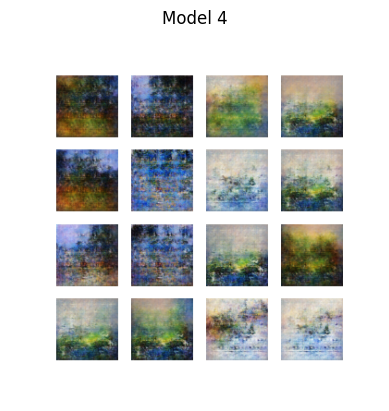

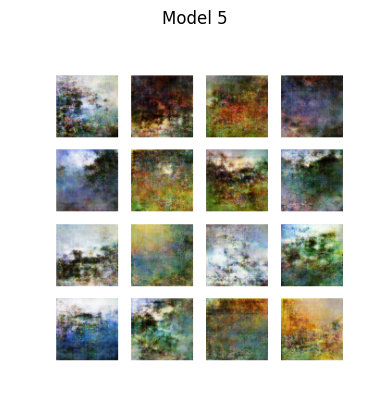

In [3]:
img = mpimg.imread('/kaggle/input/models/image_model_02.png')
imgplot = plt.imshow(img)
plt.title('Model 2')
plt.axis('off')
plt.show()

img = mpimg.imread('/kaggle/input/models/image_model_03.png')
imgplot = plt.imshow(img)
plt.title('Model 3')
plt.axis('off')
plt.show()

img = mpimg.imread('/kaggle/input/models/images_model_04.png')
imgplot = plt.imshow(img)
plt.title('Model 4')
plt.axis('off')
plt.show()

img = mpimg.imread('/kaggle/input/models/images_model_05.png')
imgplot = plt.imshow(img)
plt.title('Model 5')
plt.axis('off')
plt.show()

From a subjective perspective, we could say that models four and five are clearly the best, as they begin to create pictures, showing structures. The remaining models remain accumulations of random noise even after training.

Finally we will test our final and best model, which is model five, with the Kaggle competition score and plot the respective loss functions of generator and discriminator for this model.

The model reaches a competition score of 126.5006, which ranks us on position 113 of the leaderboard.

The score describes the memorization informed Fréchet Inception Distance, which can be defined as follows. The Fréchet Inception Distance (FID) measures the similarity between the distributions of real and generated images.

"Memorization-informed" means that the FID calculation takes into account the extent to which our model has just memorized training data. This asseses whether the model is reproducing specific examples from the training set rather than generating diverse, novel outputs.

Furthermore, the following loss functions show, that the models start to outsmart each other time and again and the pendulum is turning sometimes against the generator and then against the discriminator. This is the way GAN loss functions should principially look like. However, it is difficult to extract the performance of the GAN from loss functions alone, as they do not say anything about the predictive "performance-level", at which generator and discriminator are competing.

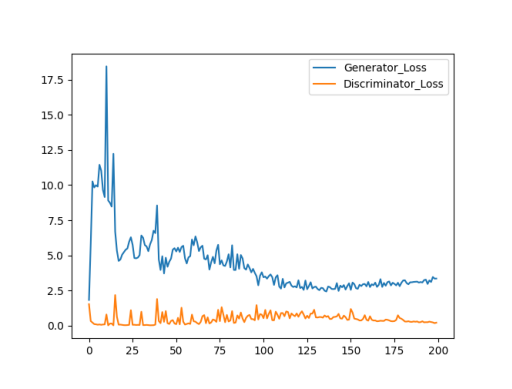

In [4]:
img = mpimg.imread('/kaggle/input/losses/losses-final-model.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

## Code to Generate the Submission Images

In [ ]:
# Kaggle Submission Notebook According to Kaggle CycleGAN notebook

#! mkdir ../images

#num_examples_to_generate = 7000

#for i in range(num_examples_to_generate):
#    seed = tf.random.normal([1, 100])
    
#    predictions = generator(seed, training=False).numpy()
#    predictions = ((predictions*0.5+0.5)*255).astype(np.uint8)
#    im = PIL.Image.fromarray(predictions[0,:,:,:])
#    im.save("../images/" + str(i) + ".jpg")

#shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

## Conclusion and Discussion

In summary, we can say, that our final model was able to generate pictures with recognizeable structures. However, attributing a monet-style on them, is in my opinion difficult, as we created the pictures from scratch and this combined with the relatively small input dataset of 300 pictures lead to the fact, that even the best output pictures looked still quite random. 

In a future work, one could put a significant amount of time and effort into the hyperparameter tuning step. We have compared five model and learning parameter sets with each other and have already seen significant improvements. It is not hard to believe that an optimal couple of generator and discriminator would again perform even better than our best model. Nevertheless, we have learned that training a GAN is quite hard, because you have to train two models in parallel and it is of no use if one model constantly outsmarts the other one. On the contrary, the models building a GAN should live in a productive balance were one learns from the other until both perform on their best level.

## Documentation of Best Model

In [ ]:
# Best model
# Source: https://www.kaggle.com/code/clementdelteil/dcgan-architectures-on-monet-s-paintings

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*512, use_bias=False, input_shape=(100,)))

    model.add(layers.Reshape((16, 16, 512)))
    
    model.add(layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1))
    
    return model

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4,beta_1=0.5)